In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%matplotlib inline

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn import set_config
set_config(display='diagram')

In [63]:
import importlib
importlib.reload(ctf)
importlib.reload(utils)

<module 'utils' from '/Users/deepakduggirala/Documents/kaggle/tmdb-box-office-prediction/utils.py'>

In [64]:
import custom_transformers as ctf
from custom_transformers import *

import utils as utils
from utils import *

## Load Data

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

## Features

Questions to ask while exploring the data:
- are there any missing values?
- is the data cut-off or transformed to exist in a min and max values?
- is the distribution skewed? - why is this a problem?
    - very few datapoints have very high / low values - so what?

Numerical:
- budget
    - there are movies with budget 0; 826 movies with below budget of 100 - what to do?; bad data; most likely that testing data will have the same problem.
    - right skewed; use log1p transformation
    - what are the units? (same units for films filmed outside US?)
    - test set have 1211 values with budget = 0 and 1245 with budget <= 500
    - either estimate budget from fields or develope two models one where budget has a meaningful value and other model without the budget feature
- popularity
    - how is it measured / interpretted?
    - what is its intended scale?
    - has outliers - valid or noise from data measurement?
- month
    - December has the highest number of releases
- year
    - follows yy convention. hard to distinguish a yy such that 00<=yy<=18 if it belongs to 1900-1918 or 2000-2018?
    - if yy > 17, assume 19yy, esle 20yy
- day of the month
- day of the week
- runtime
    - has 2 null values; replace with median
    - has 12 zero values; replace with median
- revenue
    - right skewed
    - min is 1
    - what are the units?
    - 39 movies with revenue below 100; bad data; most likely that testing data will have the same problem.
    
    
    

## Base Estimator

Conditional Pipelien: Train two models, one on data where a meaningful budget is present, other without the budget feature

In [74]:
y = np.log(train_data['revenue'])
X = train_data.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

def make_mask(X, thresh=500):
    return X['budget'] < thresh

In [112]:
class FeaturePipelines():
    def __init__(self):
        pass
        
    def get_config(self, include_budget=True):
        common_config = [
            ('popularity', make_pipeline(
                SimpleImputer(strategy='median'), 
                StandardScaler()
            ), ['popularity']),

            ('runtime', make_pipeline(
                RuntimeImputer, 
                StandardScaler()
            ), ['runtime']),

            ('release_date', make_pipeline(
                SimpleImputer(strategy='most_frequent'), 
                ReleaseDateTransformer()
            ), ['release_date'])
        ]
        
        budget_config = [
            ('budget', make_pipeline(
                SimpleImputer(strategy='median'),
                FunctionTransformer(np.log1p),
                StandardScaler()
            ), ['budget'])
        ]
        
        return (budget_config if include_budget else []) + common_config
    
    def get_features(self, include_budget=True):
        return (['budget'] if include_budget else []) + (['popularity', 'runtime', 'release_year', 'release_month', 'release_DOW'])
    

In [117]:
featurePipelines = FeaturePipelines()

prep_pipeline_A = ColumnTransformer(featurePipelines.get_config(include_budget=False), remainder='drop')
prep_pipeline_B = ColumnTransformer(featurePipelines.get_config(), remainder='drop')

full_pipeline_A = Pipeline([('prep_A', prep_pipeline_A), ('model', LinearRegression())])
full_pipeline_B = Pipeline([('prep_B', prep_pipeline_B), ('model', LinearRegression())])

base_pipeline = ConditionalPredictor(full_pipeline_A, full_pipeline_B, make_mask, 50)
base_pipeline.fit(X_train, y_train)

ConditionalPredictor(make_mask=<function make_mask at 0x108354b80>,
                     pipelineA=Pipeline(steps=[('prep_A',
                                                ColumnTransformer(transformers=[('popularity',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 ['popularity']),
                                                                                ('runtime',
                                                                                 Pipeline(steps=[('pipeline',
                                                                                                  Pipeline(steps=[('simpleimputer-1',
                                                                                                                   SimpleImp...
                                                                                                                   SimpleImputer(strategy='median')),
                                                                                                                  ('simpleimputer-2',
                                                                                                                   SimpleImputer(missing_values=0,
                                                                                                                                 strategy='median'))])),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 ['runtime']),
                                                                                ('release_date',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('releasedatetransformer',
                                                                                                  ReleaseDateTransformer())]),
                                                                                 ['release_date'])])),
                                               ('model', LinearRegression())]),
                     thresh=50)

In [118]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE"
                              ])


exp_name = f"Baseline_LR"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round([
    mean_squared_error(y_train, base_pipeline.predict(X_train), squared=False), 
    0,
    mean_squared_error(y_test, base_pipeline.predict(X_test), squared=False),
], 4)) 
expLog



,exp_name,Train MSE,Valid MSE,Test MSE
0,Baseline_LR,2.3603,0.0,2.2499


## Kaggle Submission

In [61]:
make_submission_file(exp_name, base_pipeline, X, y, test_data, 'data/sample_submission.csv', 'predictions')

kaggle competitions submit -c tmdb-box-office-prediction -f predictions/Baseline_LR.csv -m "Baseline_LR"


In [62]:
!kaggle competitions submit -c tmdb-box-office-prediction -f predictions/Baseline_LR.csv -m "Baseline_LR"

100%|████████████████████████████████████████| 100k/100k [00:01<00:00, 64.6kB/s]
Successfully submitted to TMDB Box Office Prediction

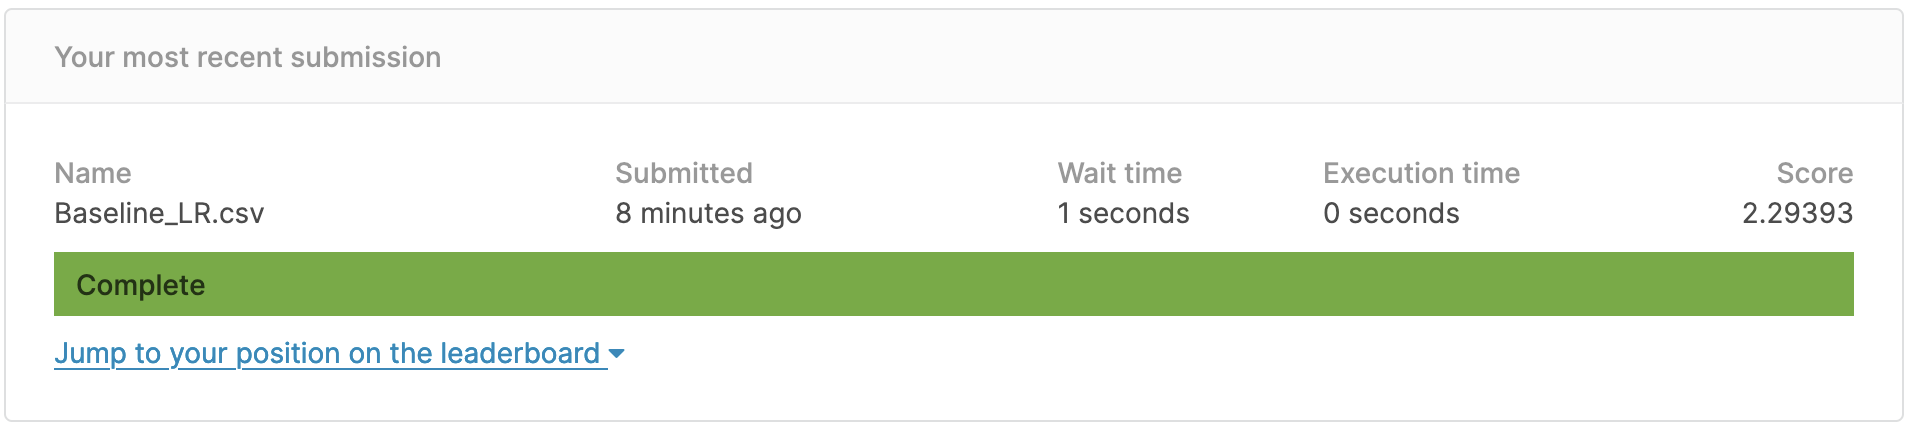

## Feature Importance

In [119]:
lr = base_pipeline.pipelineA.named_steps['model']
coef_A = pd.DataFrame(lr.coef_.reshape(1, -1), columns=featurePipelines.get_features(include_budget=False))
coef_A

,popularity,runtime,release_year,release_month,release_DOW
0,0.955263,0.325082,-0.023875,0.029534,0.17113


In [120]:
lr = base_pipeline.pipelineB.named_steps['model']
coef_B = pd.DataFrame(lr.coef_.reshape(1, -1), columns=get_features(base_pipeline, include_budget=True))
coef_B

,budget,popularity,runtime,release_year,release_month,release_DOW
0,1.506497,0.337232,0.11517,-0.018782,0.007219,-0.045502


In [121]:
x=coef_A.abs().sort_values(by=0, axis=1)
np.round(100*x/x.sum(axis=1)[0],2)

,release_year,release_month,release_DOW,runtime,popularity
0,1.59,1.96,11.37,21.6,63.48


In [122]:
x=coef_B.abs().sort_values(by=0, axis=1)
np.round(100*x/x.sum(axis=1)[0],2)

,release_month,release_year,release_DOW,runtime,popularity,budget
0,0.36,0.93,2.24,5.67,16.61,74.2
